<a href="https://colab.research.google.com/github/long-letan/colab_workspace/blob/main/FL_NonIID_GPU_HighRam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Federated Learning with Non-IID/Real-World Dataset

## Introduction

![1-XpfhCdgSUBalIGFeVb-TrQ.jpeg](https://miro.medium.com/max/2000/1*XpfhCdgSUBalIGFeVb-TrQ.jpeg)

The above image resembles the Non-IID (Independent and Identically Distributed) dataset. A collection of random variables (images in our case) is independent and identically distributed if each random variable (image) has a similar probability distribution as the others, and all are mutually independent. In part 1 of this series, we used the CIFAR10 dataset, an example of an IID type, but for the real-world use case, there needs to be a non-IID dataset to represent the real-world scenario. 

So, What is non-IID data? What changes to make in the current dataset (CIFAR10) to accumulate non-IID data for Federated Learning?

These are some of the questions which will be answered in this tutorial. This blog is part 2 of the series Preserving Data Privacy in Deep Learning and focuses on the distribution of the CIFAR10 into a non-IID dataset further divided among the clients. After completing this tutorial, you will know:
* Non-IID Dataset
* Conversion of a balanced dataset into the non-IID and real-world datasets
* Forming clients encapsulating a part of this non-IID/real-world dataset
* Use cases of image classification using federated learning

## Non-IID Dataset

Real-life data (referring to objects, values, attributes, and other aspects) is essentially non-independent and identically distributed (non-IID). In contrast, most of the existing analytical or machine learning methods are based on IID data. So, there needs to be a proper approach to handle such type of real-world dataset. This tutorial will lead to a non-IID dataset’s foundations and thus open the stage for implementing various federated learning techniques to handle the problem of getting insights from non-IID data. Non-IIDness is a common problem, causing unstable performances of deep learning models. In literature, the non-IID image classification problem is largely understudied.

NICO (Non-IID Image dataset with contexts) is one such benchmark dataset that can be further used to develop state-of-the-art machine learning models to tackle non-IID data.

In this series, CIFAR 10 is used as the benchmark dataset, and further, it is converted into a non-IID dataset. To learn more about the basics of federated learning, please head over to part 1 of this series. In this tutorial, we will create two different types of the dataset, one is replicating the real-life data, i.e. real-world dataset, and another one is the extreme example of a non-iid dataset.

### Real-World Dataset

REAL-WORLD DATASET: CIFAR 10 is randomly divided into the given number of clients. So, a client can have images from any number of classes, say, one client has images from only 1 class and another client has images from 5 classes. This type of dataset replicates the real-world scenario where clients can have different types of images.
![1-XpfhCdgSUBalIGFeVb-TrQ.jpeg](https://miro.medium.com/max/1400/1*jaKwFW2IxN0b9xypzfI3Cw.png)

Figure 1: Real-World Dataset, where CIFAR10 is divided into 20 clients

### Non-IID Dataset

The real-world dataset also comes into this category. However, for this case, a different type of distribution is done where the CIFAR10 dataset is divided based on the classes per client parameter. E.g., if classes per client=2, all the clients will have images from any two classes randomly selected from all the classes.

![1-XpfhCdgSUBalIGFeVb-TrQ.jpeg](https://miro.medium.com/max/1280/1*sckFS4hgFaoyozOUgSv4Jw.png)

Figure 2: Non-IID Dataset, classes per client=2

From the above image, one can get to know that all the clients have images from any two classes, but some outliers exist where a few clients have images from more than two classes, while some have very less number of images (client_20) when compared with the rest. Such outliers ensure that all the clients have a unique set of images. Thus an extreme example of a non-IID dataset. We can also divide the CIFAR10 dataset with classes per client = 1, where all the clients will have images from one class only with some outliers.

## Prepare Data

### Get data folder from Google Drive ###

Mount Drive folder to Google Colab

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Change directory to Data Folder & Assign data folder path to a global variable

In [29]:
DATA_FOLDER = '/content/drive/MyDrive/USYD/Datasets/DA'
!pwd

/content


## Implementation

### 1. Importing the libraries

In [3]:
import os
import random
from tqdm import tqdm
import numpy as np

from scipy.io import loadmat
import matplotlib.pyplot as plt

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torchvision import transforms 
from torchvision.transforms import Compose 
torch.backends.cudnn.benchmark=True

In [ ]:
!nvidia-smi

### 2. Hyper-parameters

1. **classes_pc**: classes per client, it is used to divide the balanced dataset to non-IID dataset by creating an unbalanced representation of classes among the clients. For e.g., if the classes_pc=1, then all the clients will have images from one class only, thus creating an extensive imbalance among the clients. (Ref: Figure 2 )
2. **num_clients**: Total number of clients among which images are to be distributed.
3. **batch_size**: Loading of the data into the data loader by batches.
4. **real_wd**: We are creating two types of datasets, one is the real-world dataset (Figure 1) and another is the extreme non-IID dataset (Figure 2). If real_wd is TRUE then dataset replicating real-life is created, i.e. real-world dataset (figure 1). If real_wd is FALSE (by default) then the extreme non-IID dataset is created.

In [4]:
real_wd = False #False: non_iid dataset, True: Real-world dataset

In [5]:
classes_pc = 2
num_clients = 20
num_selected = 6
num_rounds = 150
epochs = 5
batch_size = 32
baseline_num = 100
retrain_epochs = 20

### 3. Creating the distribution

The get_cifar10 function downloads the CIFAR10 dataset and returns x_train, y_train for training, and x_test, y_test for test purposes. Lines 5–6 downloads the dataset from torchvision, and lines 8–9 converts it into NumPy array.

In [7]:
#### get cifar dataset in x and y form

def get_cifar10():
  '''Return CIFAR10 train/test data and labels as numpy arrays'''
  data_train = torchvision.datasets.CIFAR10('./data', train=True, download=True)
  data_test = torchvision.datasets.CIFAR10('./data', train=False, download=True) 
  
  x_train, y_train = data_train.data.transpose((0,3,1,2)), np.array(data_train.targets)
  x_test, y_test = data_test.data.transpose((0,3,1,2)), np.array(data_test.targets)
  
  return x_train, y_train, x_test, y_test

def get_mnist(DATA_FOLDER):
  '''Return MNIST train/test data and labels as numpy arrays'''
  print("- loading full mnist data")
  mnist_data = loadmat(DATA_FOLDER + '/mnist_data.mat')

  mnist_train = np.reshape(mnist_data['train_28'], (55000, 28, 28, 1))
  mnist_test = np.reshape(mnist_data['test_28'], (10000, 28, 28, 1))

  # Turn to the 3 channel image with C*H*W
  mnist_data_train = np.concatenate([mnist_train, mnist_train, mnist_train], 3)
  mnist_data_test = np.concatenate([mnist_test, mnist_test, mnist_test], 3)

  mnist_labels_train = mnist_data['label_train']
  mnist_labels_test = mnist_data['label_test']

  train_label = np.argmax(mnist_labels_train, axis=1)
  test_label = np.argmax(mnist_labels_test, axis=1) 

  x_train, y_train = mnist_data_train.transpose(0, 3, 1, 2).astype(np.float32)/255.0, train_label
  x_test, y_test = mnist_data_test.transpose(0, 3, 1, 2).astype(np.float32)/255.0, test_label
  
  return x_train, y_train, x_test, y_test

def get_mnistm(DATA_FOLDER):
  '''Return MNIST train/test data and labels as numpy arrays'''
  print("-loading mnist-m data")
  mnistm_train = loadmat(DATA_FOLDER + '/mnistm_train.mat')
  mnistm_test = loadmat(DATA_FOLDER + '/mnistm_test.mat')

  mnistm_train_data = mnistm_train['train_data']
  mnistm_test_data = mnistm_test['test_data']

  # Get labels
  mnistm_labels_train = mnistm_train['train_label']
  mnistm_labels_test = mnistm_test['test_label']

  train_label = mnistm_labels_train.reshape(1,-1)[0]
  test_label = mnistm_labels_test.reshape(1,-1)[0]  
  
  x_train, y_train = mnistm_train_data.transpose(0, 3, 1, 2).astype(np.float32), train_label
  x_test, y_test = mnistm_test_data.transpose(0, 3, 1, 2).astype(np.float32), test_label
  
  return x_train, y_train, x_test, y_test

def get_usps(DATA_FOLDER):
  '''Return MNIST train/test data and labels as numpy arrays'''
  print("-loading usps data")
  usps_dataset = loadmat(DATA_FOLDER + '/usps_28x28.mat')
  usps_dataset = usps_dataset["dataset"]

  usps_train = usps_dataset[0][0]

  train_label = usps_dataset[0][1]
  train_label = train_label.reshape(-1)
  train_label[train_label == 10] = 0

  usps_train = np.concatenate([usps_train, usps_train, usps_train], 1)

  usps_test = usps_dataset[1][0]

  test_label = usps_dataset[1][1]
  test_label = test_label.reshape(-1)
  test_label[test_label == 10] = 0

  usps_test = np.concatenate([usps_test, usps_test, usps_test], 1)  

  
  x_train, y_train = usps_train, train_label
  x_test, y_test = usps_test, test_label
  
  return x_train, y_train, x_test, y_test

def print_image_data_stats(data_train, labels_train, data_test, labels_test):
  print("\nData: ")
  print(" - Train Set: ({},{}), Range: [{:.3f}, {:.3f}], Labels: {},..,{}".format(
    data_train.shape, labels_train.shape, np.min(data_train), np.max(data_train),
      np.min(labels_train), np.max(labels_train)))
  print(" - Test Set: ({},{}), Range: [{:.3f}, {:.3f}], Labels: {},..,{}".format(
    data_test.shape, labels_test.shape, np.min(data_train), np.max(data_train),
      np.min(labels_test), np.max(labels_test)))
  
def plot_image_data(data,label):
  fig, axes = plt.subplots(10,10, figsize=(10,10))
  [axi.set_axis_off() for axi in axes.ravel()]

  print(len(data))

  for i,ax in enumerate(axes.flat):
      ax.imshow(data[i].transpose(1,2,0))

The clients_rand function creates a random distribution for the clients, such that every client has an arbitrary number of images. It is one of the helper functions to be used in the upcoming code snippets.

In [8]:
def clients_rand(train_len, nclients):
  '''
  train_len: size of the train data
  nclients: number of clients
  
  Returns: to_ret
  
  This function creates a random distribution 
  for the clients, i.e. number of images each client 
  possess.
  '''
  client_tmp=[]
  sum_=0
  #### creating random values for each client ####
  for i in range(nclients-1):
    tmp=random.randint(10,100)
    sum_+=tmp
    client_tmp.append(tmp)

  client_tmp= np.array(client_tmp)
  #### using those random values as weights ####
  clients_dist= ((client_tmp/sum_)*train_len).astype(int)
  num  = train_len - clients_dist.sum()
  to_ret = list(clients_dist)
  to_ret.append(num)
  return to_ret

The split_image_data_realwd function splits the given images into n_clients. It returns a split which is further used to create the real-world dataset. This entire snippet has comments to explain what is happening in the sequential order. To understand more about this distribution, please head over to Part 2 of this series.

In [9]:
def split_image_data_realwd(data, labels, n_clients=100, verbose=True):
  '''
  Splits (data, labels) among 'n_clients s.t. every client can holds any number of classes which is trying to simulate real world dataset
  Input:
    data : [n_data x shape]
    labels : [n_data (x 1)] from 0 to n_labels(10)
    n_clients : number of clients
    verbose : True/False => True for printing some info, False otherwise
  Output:
    clients_split : splitted client data into desired format
  '''
  def break_into(n,m):
    ''' 
    return m random integers with sum equal to n 
    '''
    to_ret = [1 for i in range(m)]
    for i in range(n-m):
        ind = random.randint(0,m-1)
        to_ret[ind] += 1
    return to_ret

  #### constants ####
  n_classes = len(set(labels))
  classes = list(range(n_classes))
  np.random.shuffle(classes)
  label_indcs  = [list(np.where(labels==class_)[0]) for class_ in classes]
  
  #### classes for each client ####
  tmp = [np.random.randint(1,10) for i in range(n_clients)]
  total_partition = sum(tmp)

  #### create partition among classes to fulfill criteria for clients ####
  class_partition = break_into(total_partition, len(classes))

  #### applying greedy approach first come and first serve ####
  class_partition = sorted(class_partition,reverse=True)
  class_partition_split = {}

  #### based on class partition, partitioning the label indexes ###
  for ind, class_ in enumerate(classes):
      class_partition_split[class_] = [list(i) for i in np.array_split(label_indcs[ind],class_partition[ind])]
      
#   print([len(class_partition_split[key]) for key in  class_partition_split.keys()])

  clients_split = []
  count = 0
  for i in range(n_clients):
    n = tmp[i]
    j = 0
    indcs = []

    while n>0:
        class_ = classes[j]
        if len(class_partition_split[class_])>0:
            indcs.extend(class_partition_split[class_][-1])
            count+=len(class_partition_split[class_][-1])
            class_partition_split[class_].pop()
            n-=1
        j+=1

    ##### sorting classes based on the number of examples it has #####
    classes = sorted(classes,key=lambda x:len(class_partition_split[x]),reverse=True)
    if n>0:
        raise ValueError(" Unable to fulfill the criteria ")
    clients_split.append([data[indcs], labels[indcs]])
#   print(class_partition_split)
#   print("total example ",count)


  def print_split(clients_split): 
    print("Data split:")
    for i, client in enumerate(clients_split):
      split = np.sum(client[1].reshape(1,-1)==np.arange(n_labels).reshape(-1,1), axis=1)
      print(" - Client {}: {}".format(i,split))
    print()
      
    if verbose:
      print_split(clients_split)
  
  clients_split = np.array(clients_split)
  
  return clients_split

Now, we will create a similar split for the non-IID dataset, as explained above (with a diagram). To understand more about this distribution, please head over to Part 2 of this series.

In [10]:
def split_image_data(data, labels, n_clients=100, classes_per_client=10, shuffle=True, verbose=True):
  '''
  Splits (data, labels) among 'n_clients s.t. every client can holds 'classes_per_client' number of classes
  Input:
    data : [n_data x shape]
    labels : [n_data (x 1)] from 0 to n_labels
    n_clients : number of clients
    classes_per_client : number of classes per client
    shuffle : True/False => True for shuffling the dataset, False otherwise
    verbose : True/False => True for printing some info, False otherwise
  Output:
    clients_split : client data into desired format
  '''
  #### constants #### 
  n_data = data.shape[0]
  n_labels = np.max(labels) + 1


  ### client distribution ####
  data_per_client = clients_rand(len(data), n_clients)
  data_per_client_per_class = [np.maximum(1,nd // classes_per_client) for nd in data_per_client]
  
  # sort for labels
  data_idcs = [[] for i in range(n_labels)]
  for j, label in enumerate(labels):
    data_idcs[label] += [j]
  if shuffle:
    for idcs in data_idcs:
      np.random.shuffle(idcs)
    
  # split data among clients
  clients_split = []
  c = 0
  for i in range(n_clients):
    client_idcs = []
        
    budget = data_per_client[i]
    c = np.random.randint(n_labels)
    while budget > 0:
      take = min(data_per_client_per_class[i], len(data_idcs[c]), budget)
      
      client_idcs += data_idcs[c][:take]
      data_idcs[c] = data_idcs[c][take:]
      
      budget -= take
      c = (c + 1) % n_labels
      
    clients_split += [(data[client_idcs], labels[client_idcs])]

  def print_split(clients_split): 
    print("Data split:")
    for i, client in enumerate(clients_split):
      split = np.sum(client[1].reshape(1,-1)==np.arange(n_labels).reshape(-1,1), axis=1)
      print(" - Client {}: {}".format(i,split))
    print()
      
    if verbose:
      print_split(clients_split)
  
  clients_split = np.array(clients_split)
  
  return clients_split

The shuffle_list function takes the input of the above function(s) (split_image_data_realwd or split_image_data) and shuffles the images of each client respectively.

In [11]:
def shuffle_list(data):
  '''
  This function returns the shuffled data
  '''
  for i in range(len(data)):
    tmp_len= len(data[i][0])
    index = [i for i in range(tmp_len)]
    random.shuffle(index)
    data[i][0],data[i][1] = shuffle_list_data(data[i][0],data[i][1])
  return data


def shuffle_list_data(x, y):
  '''
  This function is a helper function, shuffles an
  array while maintaining the mapping between x and y
  '''
  inds = list(range(len(x)))
  random.shuffle(inds)
  return x[inds],y[inds]

The below code snippet converts the split into a data loader(image augmentation is done is this part) for giving this as an input to the model for training.

In [12]:
class CustomImageDataset(Dataset):
  '''
  A custom Dataset class for images
  inputs : numpy array [n_data x shape]
  labels : numpy array [n_data (x 1)]
  '''
  def __init__(self, inputs, labels, transforms=None):
      assert inputs.shape[0] == labels.shape[0]
      self.inputs = torch.Tensor(inputs)
      self.labels = torch.Tensor(labels).long()
      self.transforms = transforms 

  def __getitem__(self, index):
      img, label = self.inputs[index], self.labels[index]

      if self.transforms is not None:
        img = self.transforms(img)

      return (img, label)

  def __len__(self):
      return self.inputs.shape[0]
          

def get_default_data_transforms(train=True, verbose=True):
  transforms_train = {
  'cifar10' : transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]),#(0.24703223, 0.24348513, 0.26158784)
  }
  transforms_eval = {    
  'cifar10' : transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
  }
  if verbose:
    print("\nData preprocessing: ")
    for transformation in transforms_train['cifar10'].transforms:
      print(' -', transformation)
    print()

  return (transforms_train['cifar10'], transforms_eval['cifar10'])

The get_data_loader function uses the above helper functions and converts the CIFAR10 dataset into real-world or non-IID type, whichever is required.

In [13]:
def get_data_loaders_0(nclients,batch_size,classes_pc=10, real_wd =False ,verbose=True ):
  
  x_train, y_train, x_test, y_test = get_cifar10()

  transforms_train, transforms_eval = get_default_data_transforms(verbose=False)
  
  if real_wd:
    split = split_image_data_realwd(x_train, y_train, n_clients=nclients, verbose = verbose)
  else:  
    split = split_image_data(x_train, y_train, n_clients=nclients, 
          classes_per_client=classes_pc, verbose=verbose)
  
  split_tmp = shuffle_list(split)

  if verbose:
    print_image_data_stats(x_train, y_train, x_test, y_test)
    plot_image_data(split_tmp[0][0], split_tmp[0][1])
  
  client_loaders = [torch.utils.data.DataLoader(CustomImageDataset(x, y, transforms_train), 
                                                                batch_size=batch_size, shuffle=True) for x, y in split_tmp]

  test_loader  = torch.utils.data.DataLoader(CustomImageDataset(x_test, y_test, transforms_eval), batch_size=100, shuffle=False) 

  return client_loaders, test_loader

In [14]:
def get_data_loaders(dataset, DATA_FOLDER, nclients,batch_size,classes_pc=10, real_wd =False ,verbose=True ):
  
  if dataset == "mnist":
    x_train, y_train, x_test, y_test = get_mnist(DATA_FOLDER)
  elif dataset == "mnistm":
    x_train, y_train, x_test, y_test = get_mnistm(DATA_FOLDER)
  elif dataset == "usps":
    x_train, y_train, x_test, y_test = get_usps(DATA_FOLDER)
  
  if real_wd:
    split = split_image_data_realwd(x_train, y_train, n_clients=nclients, verbose = verbose)
  else:  
    split = split_image_data(x_train, y_train, n_clients=nclients, 
          classes_per_client=classes_pc, verbose=verbose)
  
  split_tmp = shuffle_list(split)

  if verbose:
    print_image_data_stats(x_train, y_train, x_test, y_test)
    #print(len(split_tmp[0][0]), len(split_tmp[0][1]))
    plot_image_data(split_tmp[0][0], split_tmp[0][1])
    #plot_image_data(split_tmp[1][0], split_tmp[1][1])
    #plot_image_data(split_tmp[2][0], split_tmp[2][1])
  
  client_loaders = [torch.utils.data.DataLoader(CustomImageDataset(x, y), 
                                                                batch_size=batch_size, shuffle=True) for x, y in split_tmp]

  test_loader  = torch.utils.data.DataLoader(CustomImageDataset(x_test, y_test), batch_size=100, shuffle=False) 

  return client_loaders, test_loader

Now, we are ready with all the functions to create a real-world or non-IID dataset, which can be further used by federated learning to develop state of the art models.

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Data: 
 - Train Set: ((50000, 3, 32, 32),(50000,)), Range: [0.000, 255.000], Labels: 0,..,9
 - Test Set: ((10000, 3, 32, 32),(10000,)), Range: [0.000, 255.000], Labels: 0,..,9
3813


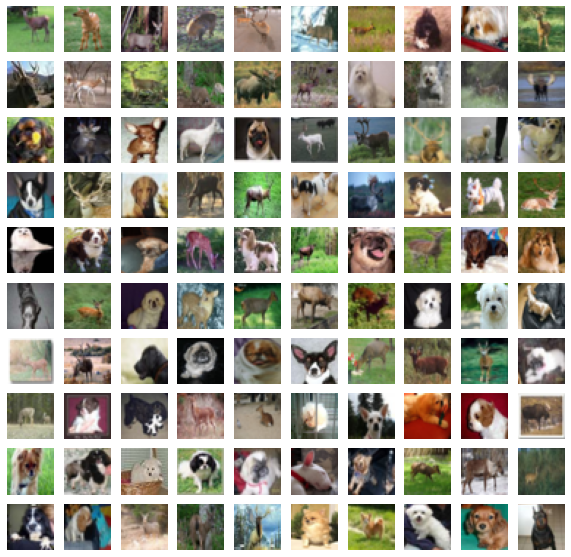

In [15]:
###### Loading the data using the above function ######
train_loader, test_loader = get_data_loaders_0(classes_pc=classes_pc, nclients= num_clients,
                                                      batch_size=batch_size,verbose=True)

- loading full mnist data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Data: 
 - Train Set: ((55000, 3, 28, 28),(55000,)), Range: [0.000, 1.000], Labels: 0,..,9
 - Test Set: ((10000, 3, 28, 28),(10000,)), Range: [0.000, 1.000], Labels: 0,..,9
3808


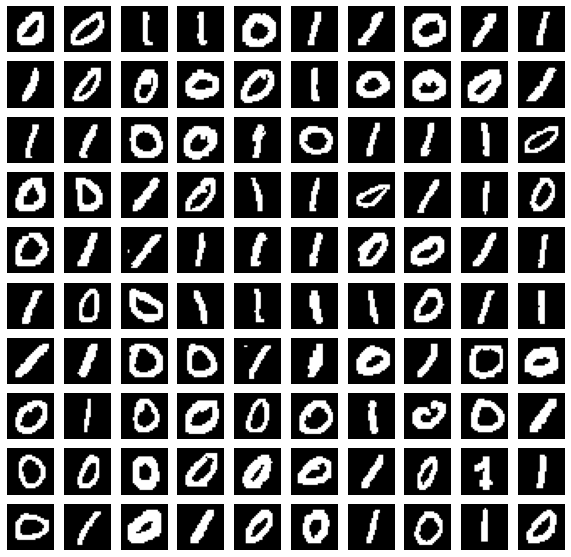

In [16]:
###### Loading the data using the above function ######
train_loader, test_loader = get_data_loaders(dataset="mnist", DATA_FOLDER=DATA_FOLDER, classes_pc=classes_pc, nclients= num_clients,
                                                      batch_size=batch_size,verbose=True)

-loading mnist-m data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Data: 
 - Train Set: ((60000, 3, 28, 28),(60000,)), Range: [0.000, 1.000], Labels: 0,..,9
 - Test Set: ((10000, 3, 28, 28),(10000,)), Range: [0.000, 1.000], Labels: 0,..,9
4790


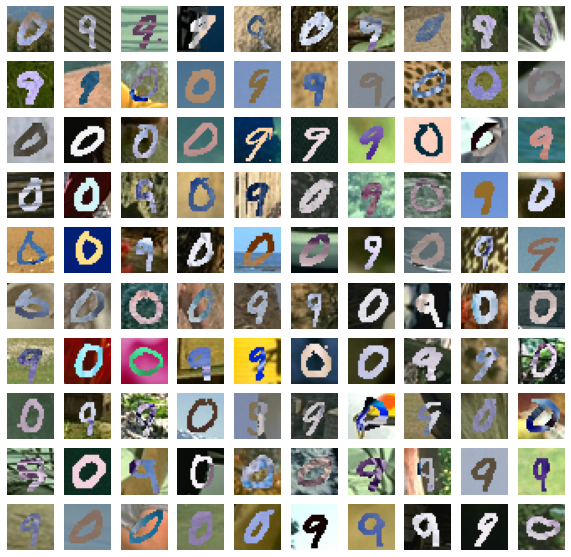

In [17]:
###### Loading the data using the above function ######
train_loader, test_loader = get_data_loaders(dataset="mnistm", DATA_FOLDER=DATA_FOLDER, classes_pc=classes_pc, nclients= num_clients,
                                                      batch_size=batch_size,verbose=True)

-loading usps data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Data: 
 - Train Set: ((7438, 3, 28, 28),(7438,)), Range: [0.000, 1.000], Labels: 0,..,9
 - Test Set: ((1860, 3, 28, 28),(1860,)), Range: [0.000, 1.000], Labels: 0,..,9
548


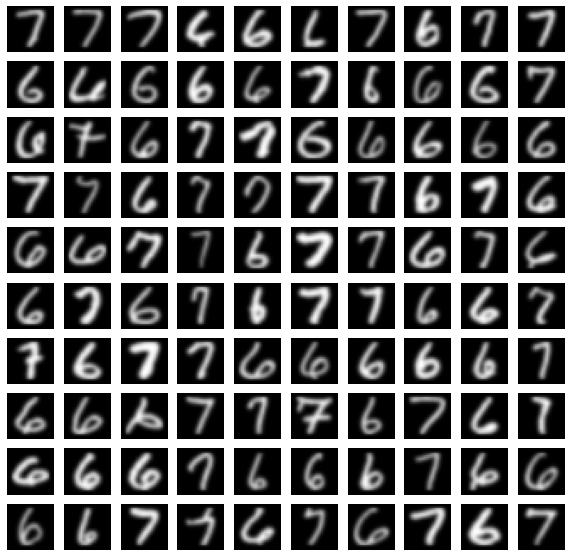

In [18]:
###### Loading the data using the above function ######
train_loader, test_loader = get_data_loaders(dataset="usps", DATA_FOLDER=DATA_FOLDER, classes_pc=classes_pc, nclients= num_clients,
                                                      batch_size=batch_size,verbose=True)

### 4. Building the Neural Network (Model Architecture)

#### VGG19

VGG19 (16 Convolution layers, 3 Fully Connected layers, 5 MaxPool layers, and 1 SoftMax layer) is used in this tutorial.

In [19]:
#################################
##### Neural Network model #####
#################################

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        output = F.log_softmax(out, dim=1)
        return output

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

#### MLP

In [ ]:
from torch import nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super(MLP, self).__init__()
        self.layer_input = nn.Linear(dim_in, dim_hidden)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.layer_hidden = nn.Linear(dim_hidden, dim_out)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, x.shape[1]*x.shape[-2]*x.shape[-1])
        x = self.layer_input(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_hidden(x)
        return self.softmax(x)


#### CNN

In [ ]:
class CNNMnist(nn.Module):
    def __init__(self, args):
        super(CNNMnist, self).__init__()
        self.conv1 = nn.Conv2d(args.num_channels, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, args.num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
class CNNFashion_Mnist(nn.Module):
    def __init__(self, args):
        super(CNNFashion_Mnist, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
class CNNCifar(nn.Module):
    def __init__(self, args):
        super(CNNCifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, args.num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

#### Model C

In [ ]:
class modelC(nn.Module):
    def __init__(self, input_size, n_classes=10, **kwargs):
        super(AllConvNet, self).__init__()
        self.conv1 = nn.Conv2d(input_size, 96, 3, padding=1)
        self.conv2 = nn.Conv2d(96, 96, 3, padding=1)
        self.conv3 = nn.Conv2d(96, 96, 3, padding=1, stride=2)
        self.conv4 = nn.Conv2d(96, 192, 3, padding=1)
        self.conv5 = nn.Conv2d(192, 192, 3, padding=1)
        self.conv6 = nn.Conv2d(192, 192, 3, padding=1, stride=2)
        self.conv7 = nn.Conv2d(192, 192, 3, padding=1)
        self.conv8 = nn.Conv2d(192, 192, 1)

        self.class_conv = nn.Conv2d(192, n_classes, 1)


    def forward(self, x):
        x_drop = F.dropout(x, .2)
        conv1_out = F.relu(self.conv1(x_drop))
        conv2_out = F.relu(self.conv2(conv1_out))
        conv3_out = F.relu(self.conv3(conv2_out))
        conv3_out_drop = F.dropout(conv3_out, .5)
        conv4_out = F.relu(self.conv4(conv3_out_drop))
        conv5_out = F.relu(self.conv5(conv4_out))
        conv6_out = F.relu(self.conv6(conv5_out))
        conv6_out_drop = F.dropout(conv6_out, .5)
        conv7_out = F.relu(self.conv7(conv6_out_drop))
        conv8_out = F.relu(self.conv8(conv7_out))

        class_out = F.relu(self.class_conv(conv8_out))
        pool_out = F.adaptive_avg_pool2d(class_out, 1)
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        return pool_out

### 5. Helper functions for Federated Learning

The baseline_data function creates a loader for the baseline data on which the client’s model is retrained before the aggregation of weights on the global server. ‘num’ is the number of images on which the retraining of client’s model on the global server is supposed to take place. Lines 9–10 gets the CIFAR10 data, and shuffle the training set. Line 12, selects num images from this shuffled dataset, following which it is used to create a Data Loader at line 14.

In [20]:
def baseline_data(num):
  '''
  Returns baseline data loader to be used on retraining on global server
  Input:
        num : size of baseline data
  Output:
        loader: baseline data loader
  '''
  xtrain, ytrain, xtmp,ytmp = get_cifar10()
  x , y = shuffle_list_data(xtrain, ytrain)

  x, y = x[:num], y[:num]
  transform, _ = get_default_data_transforms(train=True, verbose=False)
  loader = torch.utils.data.DataLoader(CustomImageDataset(x, y, transform), batch_size=16, shuffle=True)

  return loader

The client_update function trains the client model on the given private client data. This is the local training round that takes place for every selected client, i.e. num_sleected (6 in our case).

In [21]:
def client_update(client_model, optimizer, train_loader, epoch=5):
    """
    This function updates/trains client model on client data
    """
    model.train()
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = client_model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
    return loss.item()

The client_sync function synchronizes the client model (before training) with global weights. It helps in the case when a particular client has not participated in the previous communication rounds, so it makes sure that all the selected clients have the previously trained weights from the global model.

In [22]:
def client_syn(client_model, global_model):
  '''
  This function synchronizes the client model with global model
  '''
  client_model.load_state_dict(global_model.state_dict())

The server_aggregate function aggregates the model weights received from every client and updates the global model with updated weights. In this tutorial, the weighted mean of the weights is calculated. In part 1 of this series, instead of the weighted mean, the mean is used as an aggregation method.

In [23]:
def server_aggregate(global_model, client_models,client_lens):
    """
    This function has aggregation method 'wmean'
    wmean takes the weighted mean of the weights of models
    """
    total = sum(client_lens)
    n = len(client_models)
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float()*(n*client_lens[i]/total) for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

The test function is the standard function for evaluating the global model with the test dataset. It returns the test loss and test accuracy, which is used for a comparative study of different approaches.

In [24]:
def test(global_model, test_loader):
    """
    This function test the global model on test 
    data and returns test loss and test accuracy 
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = global_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    return test_loss, acc

Now, we are done with all the pre-processing of the data and some helper-functions for federated learning. So, lets deep dive into the training of the model, i.e. federated learning with the non-IID dataset.

### 6. Training the model

#### Initialize

Global model, client’s models are initialized with the VGG19, and training is done on a GPU. Line 6–11, initializes the model with VGG19 on a GPU (Cuda). At line 14, the optimizer (SGD) is defined along with the learning rate. We can also add the momentum term in our optimizer. At line 17, the baseline data is added to a loader with ‘baseline_num’ images, i.e. 100 images as defined above.

In [25]:
############################################
#### Initializing models and optimizer  ####
############################################

#### global model ##########
global_model =  VGG('VGG19').cuda()

############# client models ###############################
client_models = [ VGG('VGG19').cuda() for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global modle 

###### optimizers ################
opt = [optim.SGD(model.parameters(), lr=0.1) for model in client_models]

####### baseline data ############
loader_fixed = baseline_data(baseline_num)

Files already downloaded and verified
Files already downloaded and verified


#### Load Data

The non-IID data is loaded into a train_loader using the above functions, which ensures the data is non-IID. Classes_pc=2, num_clients=20, batch_size=32.

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Data: 
 - Train Set: ((50000, 3, 32, 32),(50000,)), Range: [0.000, 255.000], Labels: 0,..,9
 - Test Set: ((10000, 3, 32, 32),(10000,)), Range: [0.000, 255.000], Labels: 0,..,9
2154


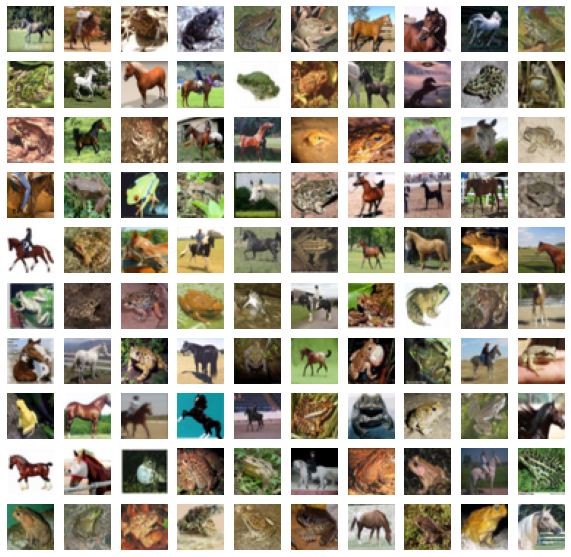

In [26]:
###### Loading the data using the above function ######
train_loader, test_loader = get_data_loaders_0(classes_pc=classes_pc, nclients= num_clients,
                                                      batch_size=batch_size,verbose=True)

#### Training

In [27]:
losses_train = []
losses_test = []
acc_test = []
losses_retrain=[]

# Runnining FL
for r in range(num_rounds):    #Communication round
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]
    client_lens = [len(train_loader[idx]) for idx in client_idx]

    # client update
    loss = 0
    for i in tqdm(range(num_selected)):
      client_syn(client_models[i], global_model)
      loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], epochs)
    losses_train.append(loss)

    # server aggregate
    #### retraining on the global server
    loss_retrain =0
    for i in tqdm(range(num_selected)):
      loss_retrain+= client_update(client_models[i], opt[i], loader_fixed, epoch=retrain_epochs)
    losses_retrain.append(loss_retrain)
    
    ### Aggregating the models
    server_aggregate(global_model, client_models,client_lens)
    test_loss, acc = test(global_model, test_loader)
    losses_test.append(test_loss)
    acc_test.append(acc)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss_retrain / num_selected, test_loss, acc))

  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 6/6 [00:15<00:00,  2.58s/it]


0-th round
average train loss 1.8 | test loss 2.24 | test acc: 0.173


100%|██████████| 6/6 [00:15<00:00,  2.54s/it]


1-th round
average train loss 2.63 | test loss 2.26 | test acc: 0.174


100%|██████████| 6/6 [00:14<00:00,  2.50s/it]


2-th round
average train loss 2.15 | test loss 2.23 | test acc: 0.183


100%|██████████| 6/6 [00:15<00:00,  2.58s/it]


3-th round
average train loss 1.93 | test loss 2.22 | test acc: 0.176


100%|██████████| 6/6 [00:15<00:00,  2.58s/it]


4-th round
average train loss 2 | test loss 2.07 | test acc: 0.206


100%|██████████| 6/6 [00:15<00:00,  2.53s/it]


5-th round
average train loss 1.62 | test loss 2.37 | test acc: 0.095


100%|██████████| 6/6 [00:14<00:00,  2.50s/it]


6-th round
average train loss 1.71 | test loss 1.98 | test acc: 0.257


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


7-th round
average train loss 1.29 | test loss 1.88 | test acc: 0.287


100%|██████████| 6/6 [00:14<00:00,  2.45s/it]


8-th round
average train loss 1.85 | test loss 1.75 | test acc: 0.325


100%|██████████| 6/6 [00:14<00:00,  2.40s/it]


9-th round
average train loss 1.65 | test loss 1.68 | test acc: 0.354


100%|██████████| 6/6 [00:15<00:00,  2.52s/it]


10-th round
average train loss 1.03 | test loss 1.9 | test acc: 0.344


100%|██████████| 6/6 [00:15<00:00,  2.50s/it]


11-th round
average train loss 1.38 | test loss 1.76 | test acc: 0.353


100%|██████████| 6/6 [00:15<00:00,  2.52s/it]


12-th round
average train loss 1.11 | test loss 1.88 | test acc: 0.328


100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


13-th round
average train loss 0.944 | test loss 2.17 | test acc: 0.339


100%|██████████| 6/6 [00:14<00:00,  2.49s/it]


14-th round
average train loss 1.04 | test loss 1.86 | test acc: 0.369


100%|██████████| 6/6 [00:14<00:00,  2.45s/it]


15-th round
average train loss 1.26 | test loss 2.12 | test acc: 0.296


100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


16-th round
average train loss 1.08 | test loss 1.75 | test acc: 0.389


100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


17-th round
average train loss 0.782 | test loss 1.93 | test acc: 0.398


100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


18-th round
average train loss 0.54 | test loss 1.84 | test acc: 0.438


100%|██████████| 6/6 [00:14<00:00,  2.40s/it]


19-th round
average train loss 0.849 | test loss 1.94 | test acc: 0.433


100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


20-th round
average train loss 0.808 | test loss 2.17 | test acc: 0.388


100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


21-th round
average train loss 1.28 | test loss 1.98 | test acc: 0.443


100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


22-th round
average train loss 0.591 | test loss 2.08 | test acc: 0.437


100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


23-th round
average train loss 1.01 | test loss 2.18 | test acc: 0.452


100%|██████████| 6/6 [00:14<00:00,  2.45s/it]


24-th round
average train loss 0.626 | test loss 2.16 | test acc: 0.471


100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


25-th round
average train loss 1.4 | test loss 2.08 | test acc: 0.459


100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


26-th round
average train loss 0.572 | test loss 2.02 | test acc: 0.460


100%|██████████| 6/6 [00:14<00:00,  2.49s/it]


27-th round
average train loss 0.0876 | test loss 2.55 | test acc: 0.484


100%|██████████| 6/6 [00:14<00:00,  2.47s/it]


28-th round
average train loss 0.623 | test loss 2.37 | test acc: 0.477


100%|██████████| 6/6 [00:14<00:00,  2.48s/it]


29-th round
average train loss 0.757 | test loss 1.92 | test acc: 0.476


100%|██████████| 6/6 [00:14<00:00,  2.45s/it]


30-th round
average train loss 0.0433 | test loss 2.4 | test acc: 0.508


100%|██████████| 6/6 [00:14<00:00,  2.45s/it]


31-th round
average train loss 0.65 | test loss 2.13 | test acc: 0.482


100%|██████████| 6/6 [00:14<00:00,  2.40s/it]


32-th round
average train loss 0.38 | test loss 2.14 | test acc: 0.509


100%|██████████| 6/6 [00:14<00:00,  2.49s/it]


33-th round
average train loss 0.313 | test loss 2.4 | test acc: 0.507


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


34-th round
average train loss 0.234 | test loss 2.22 | test acc: 0.514


100%|██████████| 6/6 [00:15<00:00,  2.51s/it]


35-th round
average train loss 0.465 | test loss 2.19 | test acc: 0.526


100%|██████████| 6/6 [00:14<00:00,  2.45s/it]


36-th round
average train loss 0.653 | test loss 2.15 | test acc: 0.539


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


37-th round
average train loss 0.0913 | test loss 2.27 | test acc: 0.552


100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


38-th round
average train loss 0.21 | test loss 2.22 | test acc: 0.517


100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


39-th round
average train loss 0.0824 | test loss 2.32 | test acc: 0.562


100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


40-th round
average train loss 0.214 | test loss 2.02 | test acc: 0.563


100%|██████████| 6/6 [00:14<00:00,  2.45s/it]


41-th round
average train loss 0.216 | test loss 2.35 | test acc: 0.522


100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


42-th round
average train loss 0.185 | test loss 2.04 | test acc: 0.585


100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


43-th round
average train loss 0.0188 | test loss 2.19 | test acc: 0.544


100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


44-th round
average train loss 0.151 | test loss 2.3 | test acc: 0.553


100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


45-th round
average train loss 0.0142 | test loss 2.42 | test acc: 0.530


100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


46-th round
average train loss 0.302 | test loss 2.19 | test acc: 0.576


100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


47-th round
average train loss 0.0313 | test loss 2.25 | test acc: 0.584


100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


48-th round
average train loss 0.436 | test loss 2.39 | test acc: 0.530


100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


49-th round
average train loss 0.285 | test loss 1.98 | test acc: 0.617


100%|██████████| 6/6 [00:14<00:00,  2.45s/it]


50-th round
average train loss 0.0296 | test loss 2.04 | test acc: 0.599


100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


51-th round
average train loss 0.431 | test loss 2.01 | test acc: 0.581


100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


52-th round
average train loss 0.0435 | test loss 2.46 | test acc: 0.568


100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


53-th round
average train loss 0.00373 | test loss 2.11 | test acc: 0.591


100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


54-th round
average train loss 0.283 | test loss 2.11 | test acc: 0.554


100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


55-th round
average train loss 0.0468 | test loss 1.92 | test acc: 0.584


100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


56-th round
average train loss 0.188 | test loss 2.19 | test acc: 0.585


100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


57-th round
average train loss 0.0954 | test loss 2.03 | test acc: 0.587


100%|██████████| 6/6 [00:14<00:00,  2.40s/it]


58-th round
average train loss 0.00249 | test loss 2.03 | test acc: 0.584


100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


59-th round
average train loss 0.00755 | test loss 1.94 | test acc: 0.611


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


60-th round
average train loss 0.401 | test loss 2.08 | test acc: 0.549


100%|██████████| 6/6 [00:14<00:00,  2.45s/it]


61-th round
average train loss 0.0306 | test loss 1.93 | test acc: 0.613


100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


62-th round
average train loss 0.00426 | test loss 2.08 | test acc: 0.593


100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


63-th round
average train loss 0.00756 | test loss 2.01 | test acc: 0.594


100%|██████████| 6/6 [00:13<00:00,  2.33s/it]


64-th round
average train loss 0.0101 | test loss 2.12 | test acc: 0.596


100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


65-th round
average train loss 0.00741 | test loss 1.92 | test acc: 0.628


100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


66-th round
average train loss 0.00259 | test loss 2.03 | test acc: 0.613


100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


67-th round
average train loss 0.0108 | test loss 2 | test acc: 0.613


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


68-th round
average train loss 0.00506 | test loss 1.99 | test acc: 0.624


100%|██████████| 6/6 [00:15<00:00,  2.52s/it]


69-th round
average train loss 0.00877 | test loss 1.93 | test acc: 0.611


100%|██████████| 6/6 [00:14<00:00,  2.48s/it]


70-th round
average train loss 0.215 | test loss 2.03 | test acc: 0.549


100%|██████████| 6/6 [00:14<00:00,  2.45s/it]


71-th round
average train loss 0.00578 | test loss 1.92 | test acc: 0.614


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


72-th round
average train loss 0.00582 | test loss 1.87 | test acc: 0.629


100%|██████████| 6/6 [00:15<00:00,  2.50s/it]


73-th round
average train loss 0.0666 | test loss 1.97 | test acc: 0.604


100%|██████████| 6/6 [00:15<00:00,  2.50s/it]


74-th round
average train loss 0.0327 | test loss 1.86 | test acc: 0.628


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


75-th round
average train loss 0.0182 | test loss 1.83 | test acc: 0.628


100%|██████████| 6/6 [00:14<00:00,  2.47s/it]


76-th round
average train loss 0.0459 | test loss 1.86 | test acc: 0.636


100%|██████████| 6/6 [00:15<00:00,  2.50s/it]


77-th round
average train loss 0.0131 | test loss 2.02 | test acc: 0.613


100%|██████████| 6/6 [00:14<00:00,  2.48s/it]


78-th round
average train loss 0.292 | test loss 1.67 | test acc: 0.638


100%|██████████| 6/6 [00:15<00:00,  2.54s/it]


79-th round
average train loss 0.0069 | test loss 1.78 | test acc: 0.634


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


80-th round
average train loss 0.0041 | test loss 1.85 | test acc: 0.626


100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


81-th round
average train loss 0.00539 | test loss 1.69 | test acc: 0.627


100%|██████████| 6/6 [00:14<00:00,  2.45s/it]


82-th round
average train loss 0.00905 | test loss 1.69 | test acc: 0.643


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


83-th round
average train loss 0.00817 | test loss 1.92 | test acc: 0.624


100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


84-th round
average train loss 0.00184 | test loss 1.84 | test acc: 0.643


100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


85-th round
average train loss 0.00624 | test loss 2.07 | test acc: 0.626


100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


86-th round
average train loss 0.0209 | test loss 1.8 | test acc: 0.628


100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


87-th round
average train loss 0.00554 | test loss 1.91 | test acc: 0.637


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


88-th round
average train loss 0.0109 | test loss 1.81 | test acc: 0.629


100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


89-th round
average train loss 0.0109 | test loss 1.91 | test acc: 0.629


100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


90-th round
average train loss 0.00639 | test loss 2.1 | test acc: 0.612


100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


91-th round
average train loss 0.00735 | test loss 1.77 | test acc: 0.664


100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


92-th round
average train loss 0.003 | test loss 1.8 | test acc: 0.636


100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


93-th round
average train loss 0.0135 | test loss 1.75 | test acc: 0.660


100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


94-th round
average train loss 0.237 | test loss 1.74 | test acc: 0.637


100%|██████████| 6/6 [00:14<00:00,  2.36s/it]


95-th round
average train loss 0.186 | test loss 1.97 | test acc: 0.617


100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


96-th round
average train loss 0.0104 | test loss 1.83 | test acc: 0.625


100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


97-th round
average train loss 0.193 | test loss 1.91 | test acc: 0.609


100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


98-th round
average train loss 0.106 | test loss 1.81 | test acc: 0.643


100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


99-th round
average train loss 0.0313 | test loss 1.66 | test acc: 0.654


100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


100-th round
average train loss 0.00755 | test loss 1.82 | test acc: 0.623


100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


101-th round
average train loss 0.0019 | test loss 1.8 | test acc: 0.627


100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


102-th round
average train loss 0.0838 | test loss 1.84 | test acc: 0.629


100%|██████████| 6/6 [00:14<00:00,  2.45s/it]


103-th round
average train loss 0.383 | test loss 2.16 | test acc: 0.587


100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


104-th round
average train loss 0.00219 | test loss 1.74 | test acc: 0.659


100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


105-th round
average train loss 0.0268 | test loss 2.03 | test acc: 0.606


100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


106-th round
average train loss 0.000783 | test loss 1.84 | test acc: 0.647


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


107-th round
average train loss 0.00963 | test loss 1.8 | test acc: 0.642


100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


108-th round
average train loss 0.00269 | test loss 1.66 | test acc: 0.673


100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


109-th round
average train loss 0.000443 | test loss 1.85 | test acc: 0.662


100%|██████████| 6/6 [00:15<00:00,  2.50s/it]


110-th round
average train loss 0.00229 | test loss 1.67 | test acc: 0.675


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


111-th round
average train loss 0.0151 | test loss 1.89 | test acc: 0.660


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


112-th round
average train loss 0.00281 | test loss 1.84 | test acc: 0.657


100%|██████████| 6/6 [00:14<00:00,  2.45s/it]


113-th round
average train loss 0.187 | test loss 1.77 | test acc: 0.628


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


114-th round
average train loss 0.0197 | test loss 1.93 | test acc: 0.599


100%|██████████| 6/6 [00:14<00:00,  2.48s/it]


115-th round
average train loss 0.00337 | test loss 1.61 | test acc: 0.661


100%|██████████| 6/6 [00:15<00:00,  2.52s/it]


116-th round
average train loss 0.00827 | test loss 1.67 | test acc: 0.653


100%|██████████| 6/6 [00:15<00:00,  2.51s/it]


117-th round
average train loss 0.0325 | test loss 1.63 | test acc: 0.647


100%|██████████| 6/6 [00:14<00:00,  2.45s/it]


118-th round
average train loss 0.116 | test loss 1.67 | test acc: 0.617


100%|██████████| 6/6 [00:15<00:00,  2.50s/it]


119-th round
average train loss 0.00207 | test loss 1.96 | test acc: 0.624


100%|██████████| 6/6 [00:15<00:00,  2.56s/it]


120-th round
average train loss 0.000802 | test loss 1.94 | test acc: 0.627


100%|██████████| 6/6 [00:15<00:00,  2.51s/it]


121-th round
average train loss 0.00726 | test loss 1.84 | test acc: 0.634


100%|██████████| 6/6 [00:15<00:00,  2.54s/it]


122-th round
average train loss 0.00662 | test loss 1.79 | test acc: 0.653


100%|██████████| 6/6 [00:15<00:00,  2.55s/it]


123-th round
average train loss 0.00709 | test loss 1.77 | test acc: 0.662


100%|██████████| 6/6 [00:14<00:00,  2.50s/it]


124-th round
average train loss 0.00586 | test loss 1.73 | test acc: 0.649


100%|██████████| 6/6 [00:14<00:00,  2.47s/it]


125-th round
average train loss 0.0477 | test loss 1.78 | test acc: 0.655


100%|██████████| 6/6 [00:15<00:00,  2.50s/it]


126-th round
average train loss 0.0267 | test loss 1.89 | test acc: 0.660


100%|██████████| 6/6 [00:15<00:00,  2.50s/it]


127-th round
average train loss 0.00335 | test loss 1.76 | test acc: 0.673


100%|██████████| 6/6 [00:15<00:00,  2.55s/it]


128-th round
average train loss 0.00441 | test loss 1.69 | test acc: 0.664


100%|██████████| 6/6 [00:14<00:00,  2.49s/it]


129-th round
average train loss 0.0152 | test loss 1.84 | test acc: 0.670


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


130-th round
average train loss 0.00561 | test loss 1.83 | test acc: 0.643


100%|██████████| 6/6 [00:15<00:00,  2.50s/it]


131-th round
average train loss 0.329 | test loss 1.92 | test acc: 0.571


100%|██████████| 6/6 [00:14<00:00,  2.49s/it]


132-th round
average train loss 0.00406 | test loss 1.89 | test acc: 0.659


100%|██████████| 6/6 [00:15<00:00,  2.51s/it]


133-th round
average train loss 0.00343 | test loss 1.85 | test acc: 0.652


100%|██████████| 6/6 [00:14<00:00,  2.47s/it]


134-th round
average train loss 0.0122 | test loss 2.04 | test acc: 0.597


100%|██████████| 6/6 [00:15<00:00,  2.50s/it]


135-th round
average train loss 0.00191 | test loss 1.88 | test acc: 0.611


100%|██████████| 6/6 [00:15<00:00,  2.51s/it]


136-th round
average train loss 0.161 | test loss 1.61 | test acc: 0.644


100%|██████████| 6/6 [00:15<00:00,  2.51s/it]


137-th round
average train loss 0.00252 | test loss 1.76 | test acc: 0.634


100%|██████████| 6/6 [00:15<00:00,  2.53s/it]


138-th round
average train loss 0.00189 | test loss 1.65 | test acc: 0.659


100%|██████████| 6/6 [00:14<00:00,  2.47s/it]


139-th round
average train loss 0.00174 | test loss 1.82 | test acc: 0.633


100%|██████████| 6/6 [00:14<00:00,  2.48s/it]


140-th round
average train loss 0.0064 | test loss 1.97 | test acc: 0.640


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


141-th round
average train loss 0.000798 | test loss 2.01 | test acc: 0.652


100%|██████████| 6/6 [00:14<00:00,  2.47s/it]


142-th round
average train loss 0.00108 | test loss 1.9 | test acc: 0.655


100%|██████████| 6/6 [00:14<00:00,  2.48s/it]


143-th round
average train loss 0.00575 | test loss 1.6 | test acc: 0.674


100%|██████████| 6/6 [00:14<00:00,  2.47s/it]


144-th round
average train loss 0.00634 | test loss 1.78 | test acc: 0.660


100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


145-th round
average train loss 0.0049 | test loss 1.71 | test acc: 0.669


100%|██████████| 6/6 [00:14<00:00,  2.47s/it]


146-th round
average train loss 0.00151 | test loss 1.74 | test acc: 0.679


100%|██████████| 6/6 [00:15<00:00,  2.51s/it]


147-th round
average train loss 0.000466 | test loss 1.63 | test acc: 0.673


100%|██████████| 6/6 [00:14<00:00,  2.50s/it]


148-th round
average train loss 0.000296 | test loss 1.61 | test acc: 0.675


100%|██████████| 6/6 [00:14<00:00,  2.50s/it]


149-th round
average train loss 0.000901 | test loss 1.8 | test acc: 0.637


Lines 1–4 create a list for keeping track of the loss and accuracy of the model on train and test dataset. 

Line 7 starts the training of individual clients in communication rounds (num_rounds). In every communication round, first, the selected clients are updated with the global weights. Then the local model is trained on the client’s device itself, following which the retraining round takes place on the global server. After retraining the client’s model, the aggregation of weights takes place.

Line 9 selects the num_selected clients from num_clients, i.e. six clients are randomly selected from a total of 20 clients. 

Training at the client’s device is done (Lines 13–17) using the client_sync(line 15), where the local models are updated with the global weights before the training, and then client_update function (line 16) is used to start the training. Once the local models are trained on the device itself, ensuring the privacy of the private data, they are sent to the global server. 

First, the retraining (lines 12–17) of these models with the baseline data is done. It is followed by the aggregation (line 27) of these local models (weights) into one global model. After updating the global model, this global model is used to test the training (line 28) with the help of the test function defined above.

This process continues for num_rounds, i.e. 150 communication rounds in our case. This is the example of the federated learning with the non-IID dataset, and similar can be done for the real-world dataset (defined in part 2), which can be further applied to a real client-based system.

### 7. Results

With 6 selected clients, each running 5 local epochs and retaining on the global server with 20 epochs on the top of 150 communication rounds, below is the truncated test result.

Comparatively, the approach used in this tutorial gives around 72% accuracy, while the one used in part 1 of this series gives around 35% accuracy when applied on a non-IID dataset. Moreover, the current approach (retraining on a global server) is far more stable when compared with other methods available.

On the comparative study of this approach (retaining on a global server with weighted-mean) with the approach used in part 1, i.e. the basic federated learning with mean, approach 2 (retraining on a global server) outclassed the one used in part 1. This entire tutorial shows the importance of retaining on a global server to handle the dataset’s non-IID issue. Hence, this study is an excellent method to deal with a non-IID dataset problem and can be used in real-world use cases.


In this tutorial, you discovered how to prepare a non-IID/real-world dataset for image classification using PyTorch.

Specifically, you learned:

1. What is non-IID (independent and identically distributed) dataset.
2. How to convert a balanced distribution into non-IID/real-world.
3. Potential use cases of object classification.

Below is the flow diagram for a quick revision of the entire process of converting the CIFAR10 dataset into clients, which can be further used in federated learning.

## SUMMARY

## CONCLUSION

The non-IID data is very difficult to train on, and the same goes for federated learning. The real-world/non-IID dataset is divided into clients (num_clients) which can be further used by federated learning and preserve the data-privacy.

In the next part of this series, we will be using this dataset with federated learning. Stay tuned for the upcoming part, which will explore the new aggregation and communication techniques used in federated learning on the non-IID dataset. In the upcoming tutorials, you will get to learn about different aggregation techniques for federated learning, homomorphic encryption of the model weights, differential privacy and it’s hybrid with federated learning.

![1*PRKQiDzbu1Nse3DfjRxh4A.png](https://miro.medium.com/max/573/1*PRKQiDzbu1Nse3DfjRxh4A.png)

Link to part 3 (Implementation of Federated Learning with non-IID dataset): https://towardsdatascience.com/preserving-data-privacy-in-deep-learning-part-3-ae2103c40c22

## REFERENCES

[1] Felix Sattler, Robust and Communication-Efficient Federated Learning from Non-IID Data, arXiv:1903.02891

[2] Yue He, Towards Non-I.I.D. image classification: A dataset and baselines, Elsevier